In [1]:
import pandas as pd
import string

In [2]:
df = pd.read_csv('srpski.csv', sep='\t')
df = df.drop(columns=['Rbr', 'SR', 'sr/sr', 'Naslov', 'Jezik'])

In [3]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].str.lower()

In [4]:
import classla

In [5]:
#classla.download('sr')

In [6]:
nlp = classla.Pipeline("sr",  processors='tokenize,lemma,pos')

2024-02-21 18:23:08 INFO: Loading these models for language: sr (Serbian):
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |
| lemma     | standard |

2024-02-21 18:23:08 INFO: Use device: cpu
2024-02-21 18:23:08 INFO: Loading: tokenize
2024-02-21 18:23:08 INFO: Loading: pos
2024-02-21 18:23:09 INFO: Loading: lemma
2024-02-21 18:23:18 INFO: Done loading processors!


In [7]:
def process_text(text):
    doc = nlp(text)
    
    lemmas = [word.lemma for sent in doc.sentences for word in sent.words]
    
    return lemmas

df['Procesiran tekst'] = df['Tekst'].apply(process_text)


In [8]:
from nltk import FreqDist

In [9]:
def remove_punctuation(words):
    punctuation = string.punctuation
    punctuation_additional = ['``', "'", "''",'...','—',"-",';', ':',"“", "„", ".."]
    words_without_punct = [word for word in words if word not in punctuation and word not in punctuation_additional] 
    return words_without_punct

df['Procesiran tekst'] = df['Procesiran tekst'].apply(remove_punctuation)

In [10]:
all_words = [word for words in df['Procesiran tekst'] for word in words]
fdist = FreqDist(all_words)
def remove_freq_words(words):
    fw_words = fdist.most_common(100)
    freq_words = [word for word,count in fw_words if count > 100 or len(word) in (1,2)]
    words_without_punct = [word for word in words if word not in freq_words] 
    return words_without_punct

df['Procesiran tekst'] = df['Procesiran tekst'].apply(remove_freq_words)


In [11]:
df.to_csv('classla_medjukorak.csv',index=False, sep='\t')

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
author_texts = df['Procesiran tekst'].apply(' '.join)

In [14]:

vectorizer = TfidfVectorizer(max_features=3000)
tf_matrix = vectorizer.fit_transform(author_texts)
tf_df = pd.DataFrame(tf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
tf_df

,1938,ah,ajduk,ako,ala,aleks,amo,ana,anđeo,ao,...,žmurka,žrtva,žuboriti,žudan,žudeti,žuditi,žudno,žulj,žut,žutilo
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
tf_df.to_csv('classla_tfidf.csv', index=False)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(tf_matrix, df['Autor'], test_size=0.2, random_state=42, stratify=df['Autor'])


In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

In [18]:
gradient_model = GradientBoostingClassifier(learning_rate=0.1,max_depth=3,min_samples_split=5, min_samples_leaf=4, n_estimators=100)
gradient_model.fit(X_train, y_train)
y_pred = gradient_model.predict(X_test)
#accuracy_gradient = accuracy_score(y_test, y_pred)
#accuracy_gradient

In [19]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(max_depth=5,min_samples_split=15, n_estimators=300)
forest_model.fit(X_train, y_train)
y_pred = forest_model.predict(X_test)
#accuracy_forest = accuracy_score(y_test, y_pred)
#accuracy_forest

In [20]:
MB_model = MultinomialNB()
MB_model.fit(X_train,y_train)
y_pred = MB_model.predict(X_test)
y_pred_train = MB_model.predict(X_train)
#accuracy_multinomial = accuracy_score(y_test, y_pred)
#accuracy_multinomial

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV



In [22]:
svm_model = SVC(kernel='sigmoid', C=10, coef0=1.0, gamma='scale')  

svm_model.fit(X_train, y_train)

SVC(C=10, coef0=1.0, kernel='sigmoid')

In [23]:
from sklearn.metrics import f1_score

In [42]:
y_pred_svc = svm_model.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f'Tačnost za SVC: {accuracy_svc}')

report_svc = classification_report(y_test, y_pred_svc)
print('Classification Report za SVC:\n', report_svc)

f1_svc = f1_score(y_test, y_pred_svc, average='weighted') 
print(f'F1 Score za SVC: {f1_svc}')

Tačnost za SVC: 0.4642857142857143
Classification Report za SVC:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.50      0.50      0.50         2
           3       1.00      0.50      0.67         2
           4       0.33      1.00      0.50         2
           5       0.50      0.50      0.50         2
           6       1.00      1.00      1.00         2
           7       0.00      0.00      0.00         1
           8       0.75      1.00      0.86         3
           9       0.00      0.00      0.00         2
          10       1.00      0.50      0.67         2
          11       1.00      0.50      0.67         2
          12       0.00      0.00      0.00         2
          13       0.20      0.33      0.25         3
          14       0.00      0.00      0.00         2

    accuracy                           0.46        28
   macro avg       0.45      0.42      0.40        28
weighted avg  

C:\Users\raden\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raden\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raden\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


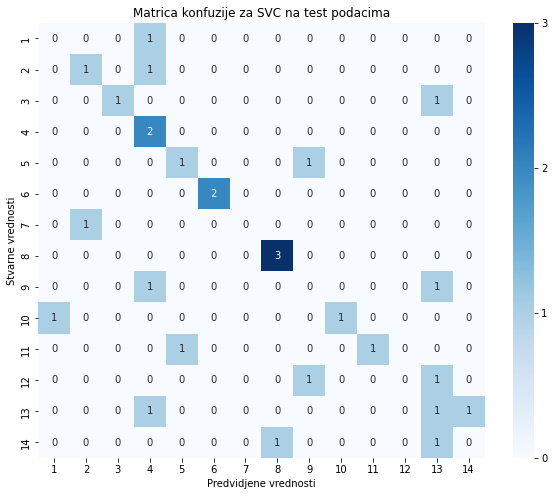

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]], dtype=int64)

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)

plt.figure(figsize=(10, 8))
heatmap=sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Blues', xticklabels=range(1,15), yticklabels=range(1,15))
plt.xlabel('Predvidjene vrednosti')
plt.ylabel('Stvarne vrednosti')
plt.title('Matrica konfuzije za SVC na test podacima')
colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks(MaxNLocator(integer=True).tick_values(conf_matrix_svc.min(), conf_matrix_svc.max()))
plt.show()
conf_matrix_svc

In [26]:
y_pred_gradient = gradient_model.predict(X_test)
accuracy_gradient = accuracy_score(y_test, y_pred_gradient)

print(f'Tačnost za Gradient Boosting: {accuracy_gradient}')

report_gradient = classification_report(y_test, y_pred_gradient)
print('Classification Report za Gradient Boosting:\n', report_gradient)

f1_gradient = f1_score(y_test, y_pred_gradient, average='weighted') 
print(f'F1 Score za Gradient Boosting: {f1_gradient}')


Tačnost za Gradient Boosting: 0.2857142857142857
Classification Report za Gradient Boosting:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.25      0.50      0.33         2
           3       1.00      0.50      0.67         2
           4       0.12      0.50      0.20         2
           5       0.33      0.50      0.40         2
           6       1.00      0.50      0.67         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         3
           9       1.00      0.50      0.67         2
          10       1.00      0.50      0.67         2
          11       0.50      0.50      0.50         2
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2

    accuracy                           0.29        28
   macro avg       0.37      0.29      0

C:\Users\raden\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raden\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raden\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


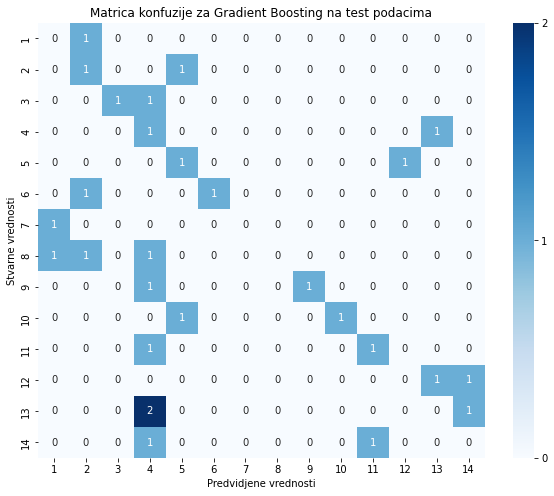

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=int64)

In [27]:

conf_matrix_gradient = confusion_matrix(y_test, y_pred_gradient)

plt.figure(figsize=(10, 8))
heatmap=sns.heatmap(conf_matrix_gradient, annot=True, fmt='d', cmap='Blues', xticklabels=range(1,15), yticklabels=range(1,15))
plt.xlabel('Predvidjene vrednosti')
plt.ylabel('Stvarne vrednosti')
plt.title('Matrica konfuzije za Gradient Boosting na test podacima')
colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks(MaxNLocator(integer=True).tick_values(conf_matrix_gradient.min(), conf_matrix_gradient.max()))
plt.show()
conf_matrix_gradient

In [28]:
y_pred_forest = forest_model.predict(X_test)
accuracy_forest = accuracy_score(y_test, y_pred_forest)

print(f'Tačnost za Random Forest: {accuracy_forest}')

report_forest = classification_report(y_test, y_pred_forest)
print('Classification Report za Random Forest:\n', report_forest)

f1_forest = f1_score(y_test, y_pred_forest, average='weighted') 
print(f'F1 Score za Random Forest: {f1_forest}')

Tačnost za Random Forest: 0.25
Classification Report za Random Forest:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       1.00      0.50      0.67         2
           4       0.17      0.50      0.25         2
           5       0.20      0.50      0.29         2
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.38      1.00      0.55         3
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.12      0.33      0.18         3
          14       0.00      0.00      0.00         2

    accuracy                           0.25        28
   macro avg       0.13      0.20      0.14        28
weighted

C:\Users\raden\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raden\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raden\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


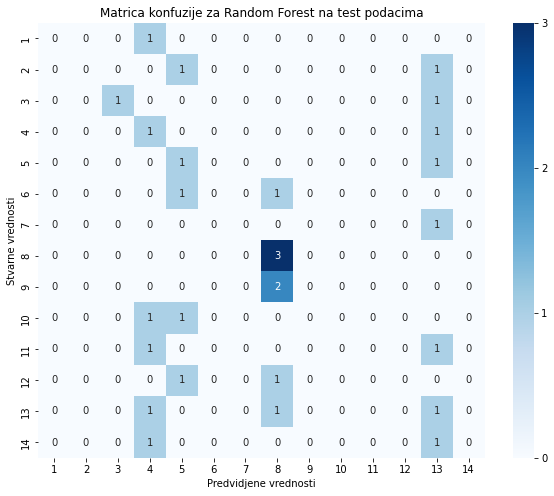

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=int64)

In [29]:

conf_matrix_forest = confusion_matrix(y_test, y_pred_forest)

plt.figure(figsize=(10, 8))
heatmap=sns.heatmap(conf_matrix_forest, annot=True, fmt='d', cmap='Blues', xticklabels=range(1,15), yticklabels=range(1,15))
plt.xlabel('Predvidjene vrednosti')
plt.ylabel('Stvarne vrednosti')
plt.title('Matrica konfuzije za Random Forest na test podacima')
colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks(MaxNLocator(integer=True).tick_values(conf_matrix_forest.min(), conf_matrix_forest.max()))
plt.show()
conf_matrix_forest

In [30]:
y_pred_multinomial = MB_model.predict(X_test)
accuracy_multinomial = accuracy_score(y_test, y_pred_multinomial)

print(f'Tačnost za Multinomial Bayes: {accuracy_multinomial}')

report_multinomial = classification_report(y_test, y_pred_multinomial)
print('Classification Report za Multinomial Bayes:\n', report_multinomial)

f1_multinomial = f1_score(y_test, y_pred_multinomial, average='weighted') 
print(f'F1 Score za Multinomial Bayes: {f1_multinomial}')

Tačnost za Multinomial Bayes: 0.21428571428571427
Classification Report za Multinomial Bayes:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.43      1.00      0.60         3
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.17      1.00      0.29         3
          14       0.00      0.00      0.00         2

    accuracy                           0.21        28
   macro avg       0.04      0.14      

C:\Users\raden\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raden\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\raden\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


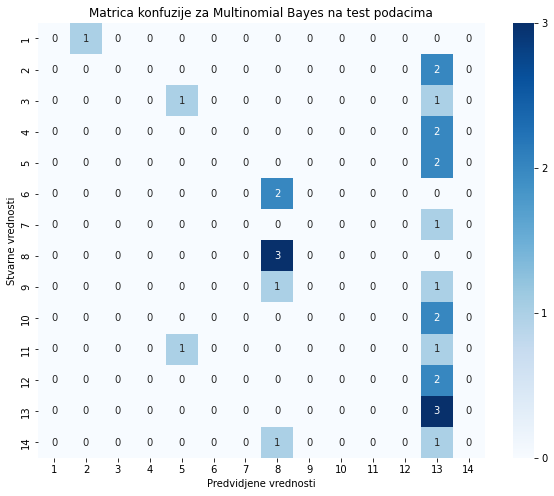

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]], dtype=int64)

In [31]:

conf_matrix_multinomial = confusion_matrix(y_test, y_pred_multinomial)

plt.figure(figsize=(10, 8))
heatmap=sns.heatmap(conf_matrix_multinomial, annot=True, fmt='d', cmap='Blues', xticklabels=range(1,15), yticklabels=range(1,15))
plt.xlabel('Predvidjene vrednosti')
plt.ylabel('Stvarne vrednosti')
plt.title('Matrica konfuzije za Multinomial Bayes na test podacima')
colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks(MaxNLocator(integer=True).tick_values(conf_matrix_multinomial.min(), conf_matrix_multinomial.max()))
plt.show()
conf_matrix_multinomial

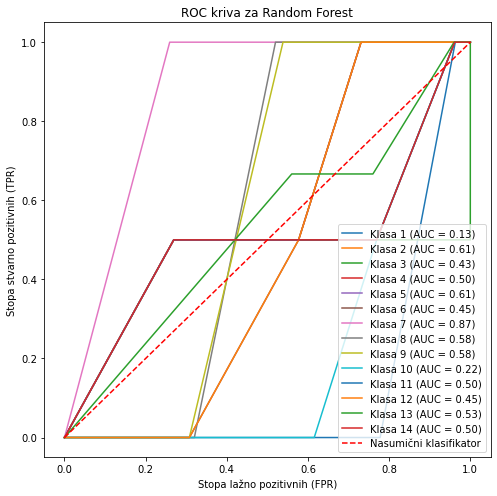

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

y_pred_forest1 = y_pred_forest.reshape(-1, 1) if len(y_pred_forest.shape) == 1 else y_pred_forest
fpr_list_forest = []
tpr_list_forest = []
roc_auc_list_forest = []

plt.figure(figsize=(8, 8))
for i in range(y_test_bin.shape[1]):
    fpr_forest, tpr_forest, _ = roc_curve(y_test_bin[:, i], y_pred_forest1[:, 0])
    roc_auc_forest = roc_auc_score(y_test_bin[:, i], y_pred_forest1[:, 0])
    
    fpr_list_forest.append(fpr_forest)
    tpr_list_forest.append(tpr_forest)
    roc_auc_list_forest.append(roc_auc_forest)
    
    plt.plot(fpr_forest, tpr_forest, label=f'Klasa {i+1} (AUC = {roc_auc_forest:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Nasumični klasifikator')
plt.xlabel('Stopa lažno pozitivnih (FPR)')
plt.ylabel('Stopa stvarno pozitivnih (TPR)')
plt.title('ROC kriva za Random Forest')
plt.legend()
plt.show()

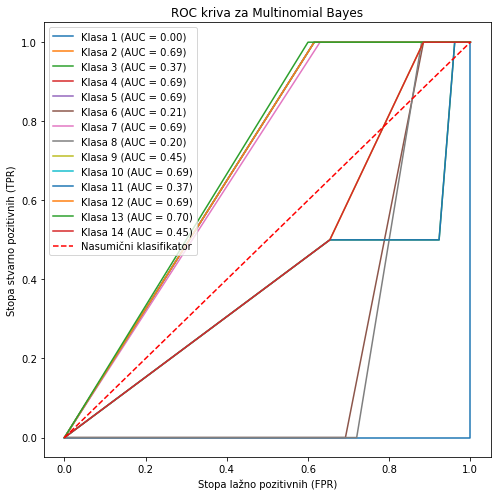

In [33]:
fpr_list_multinomial = []
tpr_list_multinomial = []
roc_auc_list_multinomial = []

y_pred_multinomial1 = y_pred_multinomial.reshape(-1, 1) if len(y_pred_multinomial.shape) == 1 else y_pred_multinomial


plt.figure(figsize=(8, 8))
for i in range(y_test_bin.shape[1]):
    fpr_multinomial, tpr_multinomial, _ = roc_curve(y_test_bin[:, i], y_pred_multinomial1[:, 0])
    roc_auc_multinomial = roc_auc_score(y_test_bin[:, i], y_pred_multinomial1[:, 0])
    
    fpr_list_multinomial.append(fpr_multinomial)
    tpr_list_multinomial.append(tpr_multinomial)
    roc_auc_list_multinomial.append(roc_auc_multinomial)
    
    plt.plot(fpr_multinomial, tpr_multinomial, label=f'Klasa {i+1} (AUC = {roc_auc_multinomial:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Nasumični klasifikator')
plt.xlabel('Stopa lažno pozitivnih (FPR)')
plt.ylabel('Stopa stvarno pozitivnih (TPR)')
plt.title('ROC kriva za Multinomial Bayes')
plt.legend()
plt.show()


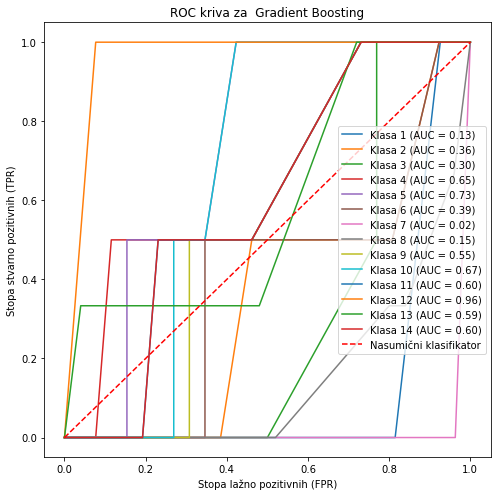

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_gradient1 = y_pred_gradient.reshape(-1, 1) if len(y_pred_gradient.shape) == 1 else y_pred_gradient
fpr_list_gradient = []
tpr_list_gradient = []
roc_auc_list_gradient = []

plt.figure(figsize=(8, 8))
for i in range(y_test_bin.shape[1]):
    fpr_gradient, tpr_gradient, _ = roc_curve(y_test_bin[:, i], y_pred_gradient1[:, 0])
    roc_auc_gradient = roc_auc_score(y_test_bin[:, i], y_pred_gradient1[:, 0])
    
    fpr_list_gradient.append(fpr_gradient)
    tpr_list_gradient.append(tpr_gradient)
    roc_auc_list_gradient.append(roc_auc_gradient)
    
    plt.plot(fpr_gradient, tpr_gradient, label=f'Klasa {i+1} (AUC = {roc_auc_gradient:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Nasumični klasifikator')
plt.xlabel('Stopa lažno pozitivnih (FPR)')
plt.ylabel('Stopa stvarno pozitivnih (TPR)')
plt.title('ROC kriva za  Gradient Boosting')
plt.legend()
plt.show()


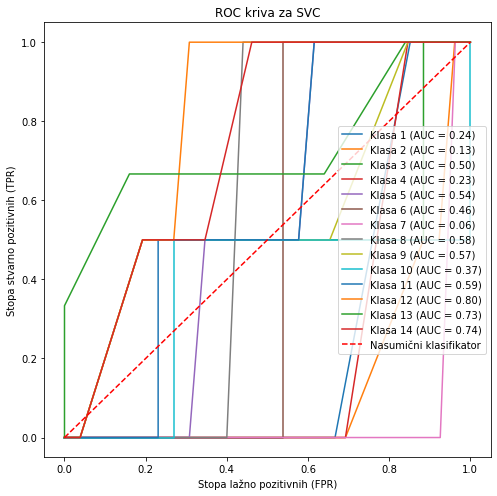

In [35]:
fpr_list_svc = []
tpr_list_svc = []
roc_auc_list_svc = []
y_pred_svc1 = y_pred_svc.reshape(-1, 1) if len(y_pred_svc.shape) == 1 else y_pred_svc


plt.figure(figsize=(8, 8))
for i in range(y_test_bin.shape[1]):
    fpr_svc, tpr_svc, _ = roc_curve(y_test_bin[:, i], y_pred_svc1[:, 0])
    roc_auc_svc = roc_auc_score(y_test_bin[:, i], y_pred_svc1[:, 0])
    
    fpr_list_svc.append(fpr_svc)
    tpr_list_svc.append(tpr_svc)
    roc_auc_list_svc.append(roc_auc_svc)
    
    plt.plot(fpr_svc, tpr_svc, label=f'Klasa {i+1} (AUC = {roc_auc_svc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Nasumični klasifikator')
plt.xlabel('Stopa lažno pozitivnih (FPR)')
plt.ylabel('Stopa stvarno pozitivnih (TPR)')
plt.title('ROC kriva za SVC')
plt.legend()
plt.show()

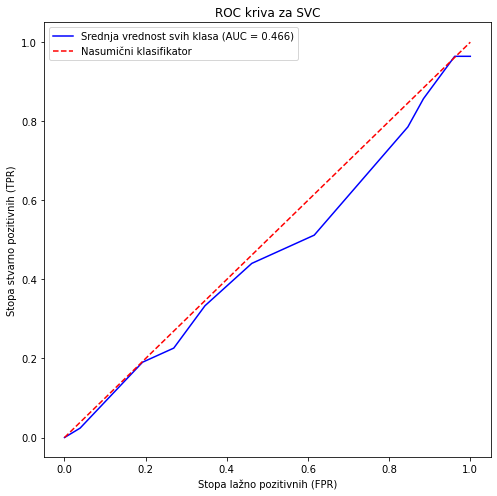

In [36]:
plt.figure(figsize=(8, 8))

for i in range(y_test_bin.shape[1]):
    fpr_svc, tpr_svc, _ = roc_curve(y_test_bin[:, i], y_pred_svc1[:, 0])
    roc_auc_svc = roc_auc_score(y_test_bin[:, i], y_pred_svc1[:, 0])

    fpr_list_svc.append(fpr_svc)
    tpr_list_svc.append(tpr_svc)
    roc_auc_list_svc.append(roc_auc_svc)

min_len_svc = min(len(fpr_svc) for fpr in fpr_list_svc)
fpr_array_svc = np.array([fpr_svc[:min_len_svc] for fpr in fpr_list_svc])
tpr_array_svc = np.array([tpr_svc[:min_len_svc] for tpr_svc in tpr_list_svc])

mean_fpr_svc = np.mean(fpr_array_svc, axis=0)
mean_tpr_svc = np.mean(tpr_array_svc, axis=0)
mean_roc_auc_svc = np.mean(roc_auc_list_svc)

plt.plot(mean_fpr_svc, mean_tpr_svc, label=f'Srednja vrednost svih klasa (AUC = {mean_roc_auc_svc:.3f})', color='blue')

plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Nasumični klasifikator')
plt.xlabel('Stopa lažno pozitivnih (FPR)')
plt.ylabel('Stopa stvarno pozitivnih (TPR)')
plt.title('ROC kriva za SVC')
plt.legend()
plt.show()


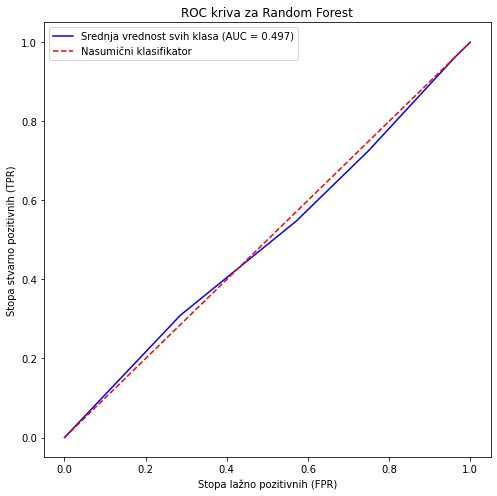

Ako je tačnost niska, a srednja vrednost AUC relativno visa, to može ukazivati na to da model pokazuje dobru sposobnost razlikovanja između klasa, 
 ali može praviti neke greške u samoj klasifikaciji.


In [37]:
plt.figure(figsize=(8, 8))

for i in range(y_test_bin.shape[1]):
    fpr_forest, tpr_forest, _ = roc_curve(y_test_bin[:, i], y_pred_forest1[:, 0])
    roc_auc_forest = roc_auc_score(y_test_bin[:, i], y_pred_forest1[:, 0])

    fpr_list_forest.append(fpr_forest)
    tpr_list_forest.append(tpr_forest)
    roc_auc_list_forest.append(roc_auc_forest)

min_len_forest = min(len(fpr_forest) for fpr_forest in fpr_list_forest)
fpr_array_forest = np.array([fpr_forest[:min_len_forest] for fpr_forest in fpr_list_forest])
tpr_array_forest = np.array([tpr_forest[:min_len_forest] for tpr_forest in tpr_list_forest])

mean_fpr_forest = np.mean(fpr_array_forest, axis=0)
mean_tpr_forest = np.mean(tpr_array_forest, axis=0)
mean_roc_auc_forest = np.mean(roc_auc_list_forest)

plt.plot(mean_fpr_forest, mean_tpr_forest, label=f'Srednja vrednost svih klasa (AUC = {mean_roc_auc_forest:.3f})', color='blue')

plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Nasumični klasifikator')
plt.xlabel('Stopa lažno pozitivnih (FPR)')
plt.ylabel('Stopa stvarno pozitivnih (TPR)')
plt.title('ROC kriva za Random Forest')
plt.legend()
plt.show()

print("Ako je tačnost niska, a srednja vrednost AUC relativno visa, to može ukazivati na to da model pokazuje dobru sposobnost razlikovanja između klasa, \n ali može praviti neke greške u samoj klasifikaciji.")

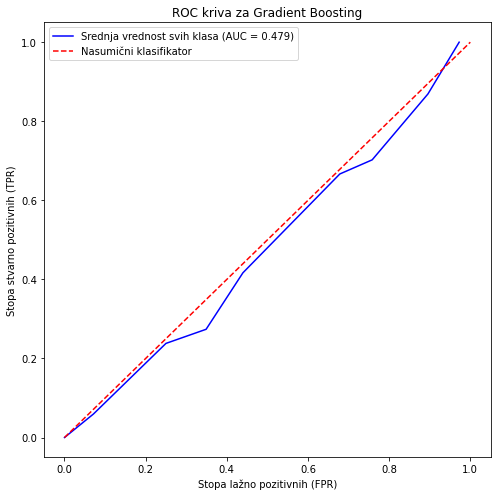

In [38]:
plt.figure(figsize=(8, 8))

for i in range(y_test_bin.shape[1]):
    fpr_gradient, tpr_gradient, _ = roc_curve(y_test_bin[:, i], y_pred_gradient1[:, 0])
    roc_auc_gradient = roc_auc_score(y_test_bin[:, i], y_pred_gradient1[:, 0])

    fpr_list_gradient.append(fpr_gradient)
    tpr_list_gradient.append(tpr_gradient)
    roc_auc_list_gradient.append(roc_auc_gradient)

min_len_gradient = min(len(fpr_gradient) for fpr_gradient in fpr_list_gradient)
fpr_array_gradient = np.array([fpr_gradient[:min_len_gradient] for fpr_gradient in fpr_list_gradient])
tpr_array_gradient = np.array([tpr_gradient[:min_len_gradient] for tpr_gradient in tpr_list_gradient])

mean_fpr_gradient = np.mean(fpr_array_gradient, axis=0)
mean_tpr_gradient = np.mean(tpr_array_gradient, axis=0)
mean_roc_auc_gradient = np.mean(roc_auc_list_gradient)

plt.plot(mean_fpr_gradient, mean_tpr_gradient, label=f'Srednja vrednost svih klasa (AUC = {mean_roc_auc_gradient:.3f})', color='blue')

plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Nasumični klasifikator')
plt.xlabel('Stopa lažno pozitivnih (FPR)')
plt.ylabel('Stopa stvarno pozitivnih (TPR)')
plt.title('ROC kriva za Gradient Boosting')
plt.legend()
plt.show()


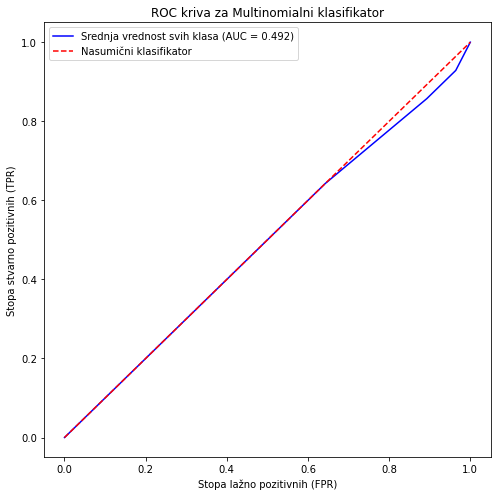

In [39]:
plt.figure(figsize=(8, 8))

for i in range(y_test_bin.shape[1]):
    fpr_multinomial, tpr_multinomial, _ = roc_curve(y_test_bin[:, i], y_pred_multinomial1[:, 0])
    roc_auc_multinomial = roc_auc_score(y_test_bin[:, i], y_pred_multinomial1[:, 0])

    fpr_list_multinomial.append(fpr_multinomial)
    tpr_list_multinomial.append(tpr_multinomial)
    roc_auc_list_multinomial.append(roc_auc_multinomial)

min_len_multinomial = min(len(fpr_multinomial) for fpr_multinomial in fpr_list_multinomial)
fpr_array_multinomial = np.array([fpr_multinomial[:min_len_multinomial] for fpr_multinomial in fpr_list_multinomial])
tpr_array_multinomial = np.array([tpr_multinomial[:min_len_multinomial] for tpr_multinomial in tpr_list_multinomial])

mean_fpr_multinomial = np.mean(fpr_array_multinomial, axis=0)
mean_tpr_multinomial = np.mean(tpr_array_multinomial, axis=0)
mean_roc_auc_multinomial = np.mean(roc_auc_list_multinomial)

plt.plot(mean_fpr_multinomial, mean_tpr_multinomial, label=f'Srednja vrednost svih klasa (AUC = {mean_roc_auc_multinomial:.3f})', color='blue')

plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Nasumični klasifikator')
plt.xlabel('Stopa lažno pozitivnih (FPR)')
plt.ylabel('Stopa stvarno pozitivnih (TPR)')
plt.title('ROC kriva za Multinomialni klasifikator')
plt.legend()
plt.show()


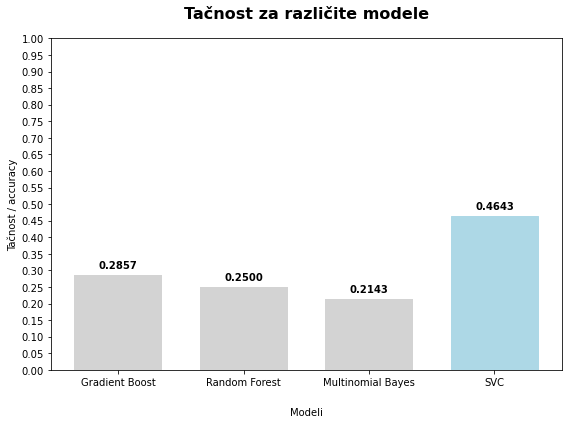

In [40]:

modeli = ['Gradient Boost', 'Random Forest', 'Multinomial Bayes', 'SVC']

accuracy_scores = [accuracy_gradient,accuracy_forest,accuracy_multinomial,accuracy_svc]
plt.figure(figsize=(8, 6))
bars = plt.bar(modeli, accuracy_scores, width=0.7, color=['lightgray', 'lightgray', 'lightgray','lightgray'])

plt.xlabel('Modeli',labelpad=20)
plt.ylabel('Tačnost / accuracy')
plt.title('Tačnost za različite modele',fontsize=16, fontweight='bold', pad=20)
plt.ylim([0, 1])  
plt.yticks([i/100 for i in range(0, 101, 5)])
max_index = accuracy_scores.index(max(accuracy_scores))
bars[max_index].set_color('lightblue')
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

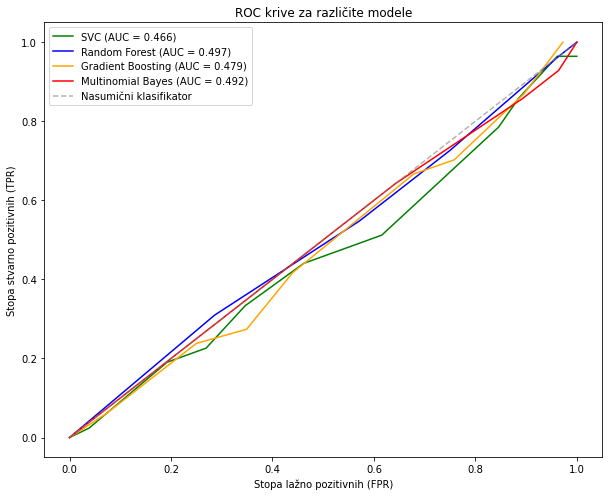

In [41]:
plt.figure(figsize=(10, 8))

plt.plot(mean_fpr_svc, mean_tpr_svc, label=f'SVC (AUC = {mean_roc_auc_svc:.3f})', color='green')

plt.plot(mean_fpr_forest, mean_tpr_forest, label=f'Random Forest (AUC = {mean_roc_auc_forest:.3f})', color='blue')

plt.plot(mean_fpr_gradient, mean_tpr_gradient, label=f'Gradient Boosting (AUC = {mean_roc_auc_gradient:.3f})', color='orange')

plt.plot(mean_fpr_multinomial, mean_tpr_multinomial, label=f'Multinomial Bayes (AUC = {mean_roc_auc_multinomial:.3f})', color='red')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Nasumični klasifikator', alpha=0.6)

plt.xlabel('Stopa lažno pozitivnih (FPR)')
plt.ylabel('Stopa stvarno pozitivnih (TPR)')
plt.title('ROC krive za različite modele')
plt.legend()
plt.show()
